# Siamese Network with Optuna for Hyperparameter Optimization

### Manage dependencies

#### Install packages

In [1]:
!python -m pip install opencv-python matplotlib tensorflow==2.10

In [2]:
!conda install -c conda-forge cudatoolkit=11.8.0 --yes

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.2




In [3]:
!pip install nvidia-cudnn-cu11==8.6.0.163 --yes


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes


In [4]:
!pip install optuna

#### Check Nvidia-GPU installation

In [5]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
!python -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

tf.Tensor(-684.5813, shape=(), dtype=float32)


2023-08-05 13:29:52.222084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 13:29:53.392406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9392 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


#### Import dependencies

In [1]:
import os
import cv2
import csv
import time
import random
import optuna
import datetime
import itertools
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras import layers, metrics, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

tf.__version__, np.__version__

('2.10.0', '1.24.2')

### Set up environment

Set GPU growth to avoid OOM errors

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Set Home path

In [3]:
HOME = os.path.split(os.getcwd())[0]
print(HOME)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

e:\Code\CowId


Set data path

In [4]:
dataset_path = os.path.join(HOME, "data", "siamese_v9_augmented/train_val")

Setting random seeds to enable consistency while testing

In [5]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

### Siamese Model construction

Get ResNet or Xception encoder

In [6]:
def get_encoder(input_shape, encoder_architecture='resnet', dropout=0.5, l2_reg=0.5, unfreeze_layers=27, dense_layer_size=128):
    if encoder_architecture == 'resnet':
        pretrained_model = ResNet152(
            input_shape=input_shape,
            weights='imagenet',
            include_top=False,
            pooling='avg',
        )
    
        for i in range(len(pretrained_model.layers)-12):
            pretrained_model.layers[i].trainable = False

        encode_model = Sequential([
            pretrained_model,
            layers.Flatten(),
            layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dropout(dropout),
            layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        ], name="Encode_Model")
        
        return encode_model


    elif encoder_architecture == 'xception':
        pretrained_model = Xception(
            input_shape=input_shape,
            weights='imagenet',
            include_top=False,
            pooling='avg',
        )
        
        for i in range(len(pretrained_model.layers)-unfreeze_layers):
            pretrained_model.layers[i].trainable = False

        encode_model = Sequential([
            pretrained_model,
            layers.Dense(dense_layer_size, kernel_regularizer=regularizers.l2(l2_reg)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(dropout)
        ], name="Encode_Model")
        return encode_model

Distance layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²

In [7]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

Creating Siamese Network Model

In [8]:
def get_siamese_network(input_shape = (128, 128, 3), encoder_architecture='resnet', dropout=0.5, l2_reg=0.5, unfreeze_layers = 27, dense_layer_size=128):
    encoder = get_encoder(input_shape, encoder_architecture, dropout, l2_reg, unfreeze_layers, dense_layer_size)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

Create entire Siamese Network

In [9]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.5):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

### Helper functions

Generates the triplets of anchor, positive, negative for all the cows

In [10]:
def generate_triplets(output_loc):
    if not os.path.exists(output_loc):
        os.makedirs(output_loc)    
    triplets = []
    cow_dirs = os.listdir(dataset_path)    
    for cow in cow_dirs:
        neg_dir_list = cow_dirs.copy()
        neg_dir_list.remove(cow)        
        all_cows_except_current = []        
        for neg_cow in neg_dir_list:
            neg_list = os.listdir(os.path.join(dataset_path, neg_cow))
            neg_list = list(map(lambda x: os.path.join(dataset_path, neg_cow, x), neg_list))
            all_cows_except_current.extend(neg_list)        
        path_to_cow = os.path.join(dataset_path, cow)        
        if "cow" in path_to_cow:
            pos_list = os.listdir(os.path.join(dataset_path, cow))
            pos_list = list(map(lambda x: os.path.join(dataset_path, cow, x), pos_list))            
            while len(pos_list) > 1 and len(all_cows_except_current) > 0:
                rand_pos_index = random.randrange(len(pos_list)) 
                positive_elem = pos_list.pop(rand_pos_index)                
                rand_anc_index = random.randrange(len(pos_list))
                anchor_elem = pos_list.pop(rand_anc_index)                
                rand_neg_index = random.randrange(len(all_cows_except_current))
                neg_elem = all_cows_except_current.pop(rand_neg_index)                
                triplets.append((positive_elem, anchor_elem, neg_elem))      
    print(len(triplets))    
    with open(os.path.join(output_loc, 'triplets.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in triplets:
            writer.writerow(row)

Split dataset into train and test

In [11]:
def split_dataset_by_cow(saving_route, val_cows=['cow_2', 'cow_6', 'cow_15', 'cow_17']):
    train_set = []
    val_set = []

    with open(os.path.join(saving_route, 'triplets.csv'), newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            cow_id = row[0].split('\\')[-2]
            if cow_id in val_cows:
                val_set.append(row)
            else:
                train_set.append(row)
    random.shuffle(train_set)
    return train_set, val_set


Read image from path to memory

In [12]:
def read_image(path, target_size=(128, 128)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    try:
        image = cv2.resize(image, target_size)
    except:
        print(path)
    return image

Get a batch of images to apply preprocessing

In [13]:
def get_batch(triplet_list, batch_size=64, preprocess=True, encoder_architecture='resnet'):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            if a.lower().endswith('.jpg') and p.lower().endswith('.jpg') and n.lower().endswith('.jpg'):
                anchor.append(read_image(a))
                positive.append(read_image(p))
                negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            if encoder_architecture == 'resnet':
                anchor = resnet_preprocess_input(anchor)
                positive = resnet_preprocess_input(positive)
                negative = resnet_preprocess_input(negative)
            elif encoder_architecture == 'xception':
                anchor = xception_preprocess_input(anchor)
                positive = xception_preprocess_input(positive)
                negative = xception_preprocess_input(negative)
        
        yield ([anchor, positive, negative])

Create encoder to save

In [14]:
def extract_encoder(model, encoder_architecture='resnet', dense_layer_size=512):
    encoder = get_encoder((128, 128, 3), encoder_architecture=encoder_architecture, dense_layer_size=dense_layer_size)
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

Calculate the distance between two images

In [15]:
def calculate_distances(encoder, cows_list1, cows_list2):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(np.array(cows_list1))
    tensor2 = encoder.predict(np.array(cows_list2))

    # Calculate the Euclidean distance
    distance = np.sqrt(np.sum(np.square(tensor1 - tensor2), axis=-1))

    return distance

Classify if the cow images are the same

In [16]:
def classify_images(encoder, cows_list1, cows_list2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(cows_list1)
    tensor2 = encoder.predict(cows_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    print(prediction)
    return prediction

In [17]:
def create_prediction(encoder, val_triplets, threshold=0.5, encoder_architecture='resnet'):
    pos_list = np.array([])
    neg_list = np.array([])
    for data in get_batch(val_triplets, batch_size=64, preprocess=True, encoder_architecture=encoder_architecture):
        a, p, n = data
        pos_list = np.append(pos_list, classify_images(encoder, a, p, threshold))
        neg_list = np.append(neg_list, classify_images(encoder, a, n, threshold))
        
    y_true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    y_pred = np.append(pos_list, neg_list)
    return y_true, y_pred

In [18]:
def step_decay(epoch, lr, drop, epochs_drop):
    initial_lr = lr
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

### Model metrics

This function prints and plots the confusion matrix

In [19]:
def plot_confusion_matrix(true, pred, dir):
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.clf()
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':12}, pad = 20)
    
    plt.tight_layout()  # Adjust layout

    plt.savefig(os.path.join(dir, 'confusion_matrix.png'))
    plt.clf()
    return f1_score(true, pred)

Plot training and validation metrics

In [20]:
def plot_metrics(history, save_path):
    plt.rcParams.update({'font.size': 14})  # Increase font size
    fig, axs = plt.subplots(2, figsize=(12, 10))  # Increase figure size

    # create accuracy subplot
    axs[0].plot(history['train_acc'], label='Train Accuracy', linewidth=2)  # Increase line width
    axs[0].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)  # Increase line width
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc='lower right')
    axs[0].set_title("Accuracy Evaluation")
    axs[0].grid(True)  # Add grid for better visibility of values

    # create loss subplot
    axs[1].plot(history['train_loss'], label='Train Loss', linewidth=2)  # Increase line width
    axs[1].plot(history['val_loss'], label='Validation Loss', linewidth=2)  # Increase line width
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc='upper right')
    axs[1].set_title("Loss Evaluation")
    axs[1].grid(True)  # Add grid for better visibility of values

    # Improve layout
    plt.tight_layout()
    
    plt.savefig(os.path.join(save_path, 'metrics_plot.png'))
    plt.close()


Validation test metrics

In [21]:
def test_on_triplets(val_triplets, siamese_model, batch_size = 256, encoder_architecture='resnet'):
    pos_scores, neg_scores = [], []
    test_loss, test_acc = [], []

    for data in get_batch(val_triplets, batch_size=batch_size, preprocess=True, encoder_architecture=encoder_architecture):
        loss = siamese_model.test_on_batch(data)

        pos_scores, neg_scores = siamese_model.predict(data)
        correct_preds = np.sum(np.array(pos_scores) < np.array(neg_scores))
        acc = correct_preds / len(pos_scores)
        test_loss.append(loss)
        test_acc.append(acc)
    
    test_loss = sum(test_loss)/len(test_loss)
    test_acc = sum(test_acc)/len(test_acc)
    
    print(f"Accuracy on validation = {test_acc:.5f}")
    print(f"Loss on validation = {test_loss:.5f}")
    print('-----------------------------------')

    return (test_acc, test_loss)

Create logs

In [22]:
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    return result

### Model Training

Set saving path

In [23]:
saving_route = os.path.join(HOME, 'data', 'siamese_triplets_lists')

Create triplets list

In [24]:
generate_triplets(saving_route)

26548


Split triplets set into validation and training

In [25]:
train_triplets, val_triplets = split_dataset_by_cow(saving_route)

Check triplets construction

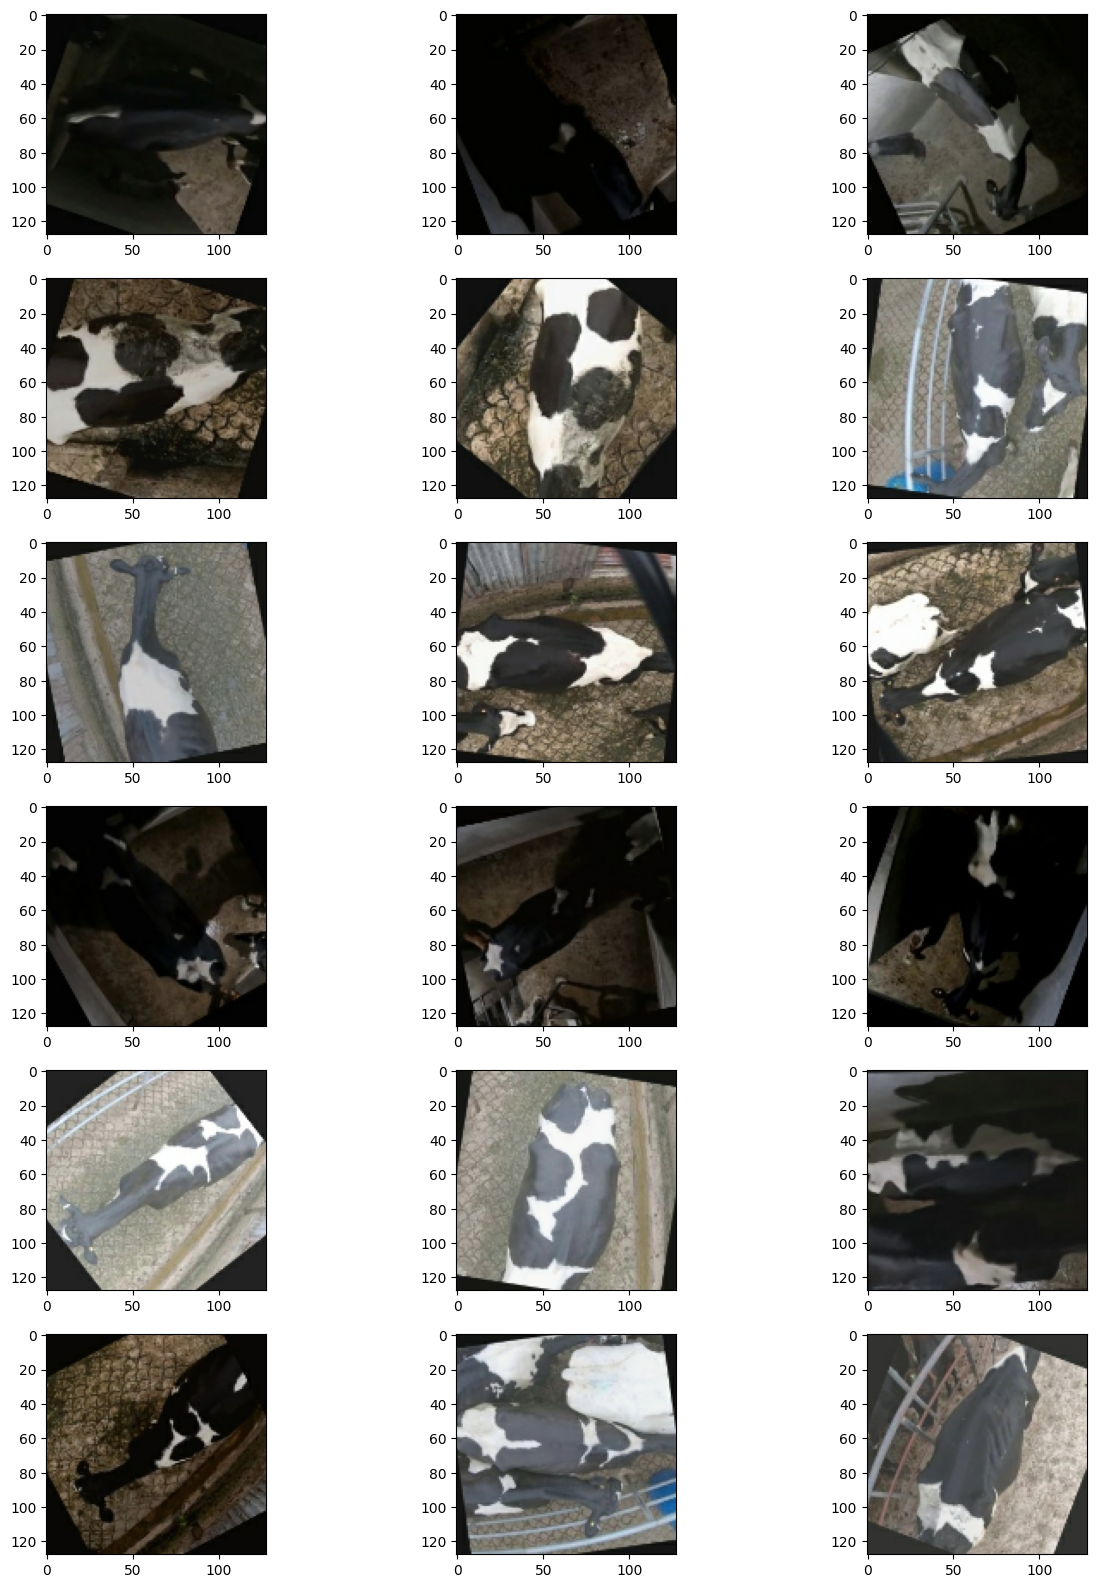

In [26]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplets, batch_size=num_plots, preprocess=False, encoder_architecture='resnet'): 
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
    break

Handle Optuna runs folder structure

In [27]:
store_folder = 'optuna_siamese_runs'

folder_names = [int(name) for name in os.listdir(os.path.join(HOME, 'data', store_folder)) if os.path.isdir(os.path.join(HOME, 'data', store_folder, name))]
sorted_folders = sorted(folder_names, reverse=True)

OPTUNA_RUN_ITERATION = 0 if len(sorted_folders) == 0 else sorted_folders[0]

Define Optuna training objective

In [30]:
def objective(trial):
    global OPTUNA_RUN_ITERATION
    OPTUNA_RUN_ITERATION += 1
    OPTUNA_DIR = os.path.join(HOME, 'data', store_folder, str(OPTUNA_RUN_ITERATION))

    if not os.path.exists(OPTUNA_DIR): 
        os.makedirs(OPTUNA_DIR)

    # TensorBoard callback
    log_dir = os.path.join(OPTUNA_DIR, "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    param_grid = {
                  "ARCHITECTURE": 'xception', # trial.suggest_categorical("ARCHITECTURE", ["resnet", "xception"]), 
                  "LR": -4, # trial.suggest_int("LR", -6, -4, step=1),
                  "LR_DROP": trial.suggest_int("DROPOUT", 8, 10, step=1)/10,
                  "LR_EPOCHS_DROP": 1,
                  'EPOCHS': 20, # trial.suggest_int("EPOCHS", 10, 50, step=10),
                  'BATCH_SIZE': 32,
                  "DROPOUT": trial.suggest_int("DROPOUT", 2, 6, step=2)/10,
                  "L2_REG": 0.2, # trial.suggest_int("L2_REG", 1, 5, step=2)/5,
                  "PRETRAINED_TRAINING_LAYERS": trial.suggest_int("PRETRAINED_TRAINING_LAYERS", 24, 36, step=6),
                  "DENSE_LAYER_NEURONS": 64*trial.suggest_int("DENSE_LAYER_NEURONS", 1, 2, step=1),
                  }

    LR = 10**param_grid["LR"]
    EPOCHS = param_grid["EPOCHS"]
    BATCH_SIZE = param_grid["BATCH_SIZE"]
    

    lr_scheduler = LearningRateScheduler(step_decay)

    
    siamese_network = get_siamese_network(encoder_architecture=param_grid["ARCHITECTURE"], 
                                          dropout=param_grid["DROPOUT"], 
                                          l2_reg=param_grid["L2_REG"], 
                                          unfreeze_layers=param_grid["PRETRAINED_TRAINING_LAYERS"],
                                          dense_layer_size=param_grid["DENSE_LAYER_NEURONS"]
                                          )

    siamese_model = SiameseModel(siamese_network)

    optimizer = Adam(learning_rate=LR)

    with open(os.path.join(HOME, 'data', OPTUNA_DIR, 'params.json'), 'w') as f:
        json.dump(param_grid, f)

    siamese_model.compile(optimizer=optimizer)

    history = {
        'train_acc': [],
        'val_acc': [],
        'train_loss': [],
        'val_loss': []
    }

    patience = 10
    best_metric = np.inf
    min_loss = np.inf
    # best_metric = -np.inf
    # max_acc = -np.inf
    epochs_no_improve = 0 

    for epoch in range(1, EPOCHS+1):
        t = time.time()
        print(f"Started training EPOCH {epoch}")

        # Training the model on train data
        epoch_loss, epoch_acc = [], []
        for data in get_batch(train_triplets, batch_size=BATCH_SIZE, preprocess=True, encoder_architecture=param_grid["ARCHITECTURE"]):
            new_lr = step_decay(epoch-1, LR, param_grid["LR_DROP"], param_grid["LR_EPOCHS_DROP"])
            tf.keras.backend.set_value(siamese_model.optimizer.lr, new_lr)
            # Compute the loss for this batch
            loss = siamese_model.train_on_batch(data)
            # Get predictions from the model
            pos_scores, neg_scores = siamese_model.predict(data)
            # Accuracy is calculated as the ratio of correct predictions
            correct_preds = np.sum(np.array(pos_scores) < np.array(neg_scores))
            acc = correct_preds / len(pos_scores)
            # Append the loss and accuracy to the respective lists
            epoch_loss.append(loss)
            epoch_acc.append(acc)
            
        epoch_loss = sum(epoch_loss)/len(epoch_loss)
        epoch_acc = sum(epoch_acc)/len(epoch_acc)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
        print(f"Loss on train    = {epoch_loss:.5f}")
        print(f"Accuracy on train = {epoch_acc:.5f}")

        # Testing the model on test data
        metric = test_on_triplets(val_triplets, siamese_model, batch_size=BATCH_SIZE, encoder_architecture=param_grid["ARCHITECTURE"])
        val_loss, val_acc = metric[1], metric[0]  # assuming loss is the second value in the metric tuple

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_loss <= min_loss:
            siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model")) 
            min_loss = val_loss

        if val_loss < best_metric:
            best_metric = val_loss
            epochs_no_improve = 0  
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping: Model did not improve below {best_metric:.5f} for {patience} epochs')
            break

    siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model-final")) 

    plot_metrics(history, OPTUNA_DIR)

    encoder = extract_encoder(siamese_model, encoder_architecture=param_grid["ARCHITECTURE"],
                                              dense_layer_size=param_grid["DENSE_LAYER_NEURONS"])
    encoder.save_weights(os.path.join(OPTUNA_DIR, "encoder"))
    encoder.save(os.path.join(OPTUNA_DIR, "encoder.h5"))


    # Iterate over possible thresholds to find the best
    best_f1 = 0
    best_threshold = 0

    for threshold in [0.5, 1, 4, 6, 10, 14, 18, 24]:
        y_true, y_pred = create_prediction(encoder, val_triplets, threshold, encoder_architecture=param_grid["ARCHITECTURE"])
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    y_true, y_pred = create_prediction(encoder, val_triplets, best_threshold, encoder_architecture=param_grid["ARCHITECTURE"])
        
    f1 = plot_confusion_matrix(y_true, y_pred, os.path.join(OPTUNA_DIR))

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Vale precision: {precision:.5f}")
    print(f"Vale recall: {recall:.5f}")
    print(f"Vale F1-score: {f1:.5f}")

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "best_threshold": best_threshold, 
        "last_lr": new_lr,
    }

    with open(os.path.join(HOME, 'data', OPTUNA_DIR, 'metrics.json'), 'w') as f:
        json.dump(metrics, f)
        
    # Memory cleanup
    del siamese_model
    del encoder
    del history
    tf.keras.backend.clear_session()
    gc.collect()

    return f1

Call optuna training loop

In [31]:
study = optuna.create_study(directions=['maximize'], storage=f"sqlite:///{os.path.join(HOME, 'data', 'siames2.db')}", load_if_exists=True)
study.optimize(objective, n_trials=8)

[I 2023-08-06 23:15:47,461] A new study created in RDB with name: no-name-85f0c676-3681-4e1b-ae2e-ce93e1126221
e:\Code\CowId\.conda\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "DROPOUT"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 6, 'high': 10}
  warnings.warn(


Started training EPOCH 1
1/1 [==============================] - 1s 1s/step

EPOCH: 1 	 (Epoch done in 146 sec)
Loss on train    = 0.21585
Accuracy on train = 0.96453
1/1 [==============================] - 0s 18ms/step
Accuracy on validation = 0.93286
Loss on validation = 0.29441
-----------------------------------
Started training EPOCH 2
1/1 [==============================] - 0s 19ms/step

EPOCH: 2 	 (Epoch done in 200 sec)
Loss on train    = 0.03295
Accuracy on train = 0.99511
1/1 [==============================] - 0s 18ms/step
Accuracy on validation = 0.91919
Loss on validation = 0.58619
-----------------------------------
Started training EPOCH 3
1/1 [==============================] - 0s 21ms/step

EPOCH: 3 	 (Epoch done in 206 sec)
Loss on train    = 0.00854
Accuracy on train = 0.99911
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.92773
Loss on validation = 0.49558
-----------------------------------
Started training EPOCH 4
1/1 [==================

[I 2023-08-06 23:56:11,616] Trial 0 finished with value: 0.8499939268796306 and parameters: {'DROPOUT': 6, 'PRETRAINED_TRAINING_LAYERS': 30, 'DENSE_LAYER_NEURONS': 2}. Best is trial 0 with value: 0.8499939268796306.
e:\Code\CowId\.conda\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "DROPOUT"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 6, 'high': 10}
  warnings.warn(


Started training EPOCH 1
1/1 [==============================] - 1s 841ms/step

EPOCH: 1 	 (Epoch done in 142 sec)
Loss on train    = 0.24822
Accuracy on train = 0.95830
1/1 [==============================] - 0s 18ms/step
Accuracy on validation = 0.92114
Loss on validation = 0.34174
-----------------------------------
Started training EPOCH 2
1/1 [==============================] - 0s 18ms/step

EPOCH: 2 	 (Epoch done in 128 sec)
Loss on train    = 0.04122
Accuracy on train = 0.99395
1/1 [==============================] - 0s 18ms/step
Accuracy on validation = 0.92383
Loss on validation = 0.38997
-----------------------------------
Started training EPOCH 3
1/1 [==============================] - 0s 18ms/step

EPOCH: 3 	 (Epoch done in 131 sec)
Loss on train    = 0.00812
Accuracy on train = 0.99911
1/1 [==============================] - 0s 17ms/step
Accuracy on validation = 0.92236
Loss on validation = 0.44986
-----------------------------------
Started training EPOCH 4
1/1 [===============

[I 2023-08-07 00:33:22,811] Trial 1 finished with value: 0.8417525773195876 and parameters: {'DROPOUT': 6, 'PRETRAINED_TRAINING_LAYERS': 24, 'DENSE_LAYER_NEURONS': 2}. Best is trial 0 with value: 0.8499939268796306.
e:\Code\CowId\.conda\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "DROPOUT"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 6, 'high': 10}
  warnings.warn(


Started training EPOCH 1
1/1 [==============================] - 1s 834ms/step

EPOCH: 1 	 (Epoch done in 142 sec)
Loss on train    = 0.22772
Accuracy on train = 0.96115
1/1 [==============================] - 0s 18ms/step
Accuracy on validation = 0.90723
Loss on validation = 0.39729
-----------------------------------
Started training EPOCH 2
1/1 [==============================] - 0s 18ms/step

EPOCH: 2 	 (Epoch done in 129 sec)
Loss on train    = 0.04177
Accuracy on train = 0.99373
1/1 [==============================] - 0s 18ms/step
Accuracy on validation = 0.91504
Loss on validation = 0.48675
-----------------------------------
Started training EPOCH 3
1/1 [==============================] - 0s 26ms/step

EPOCH: 3 	 (Epoch done in 129 sec)
Loss on train    = 0.01121
Accuracy on train = 0.99853
1/1 [==============================] - 0s 17ms/step
Accuracy on validation = 0.92554
Loss on validation = 0.51056
-----------------------------------
Started training EPOCH 4
1/1 [===============

[I 2023-08-07 01:10:01,738] Trial 2 finished with value: 0.8376989597693947 and parameters: {'DROPOUT': 6, 'PRETRAINED_TRAINING_LAYERS': 24, 'DENSE_LAYER_NEURONS': 1}. Best is trial 0 with value: 0.8499939268796306.
e:\Code\CowId\.conda\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "DROPOUT"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 6, 'high': 10}
  warnings.warn(


Started training EPOCH 1
1/1 [==============================] - 1s 837ms/step

EPOCH: 1 	 (Epoch done in 148 sec)
Loss on train    = 0.19799
Accuracy on train = 0.96862
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.90942
Loss on validation = 0.39933
-----------------------------------
Started training EPOCH 2
1/1 [==============================] - 0s 18ms/step

EPOCH: 2 	 (Epoch done in 138 sec)
Loss on train    = 0.03941
Accuracy on train = 0.99569
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.92847
Loss on validation = 0.40847
-----------------------------------
Started training EPOCH 3
1/1 [==============================] - 0s 17ms/step

EPOCH: 3 	 (Epoch done in 139 sec)
Loss on train    = 0.01550
Accuracy on train = 0.99902
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.92798
Loss on validation = 0.58395
-----------------------------------
Started training EPOCH 4
1/1 [===============

[I 2023-08-07 01:48:08,562] Trial 3 finished with value: 0.8393348486661084 and parameters: {'DROPOUT': 8, 'PRETRAINED_TRAINING_LAYERS': 36, 'DENSE_LAYER_NEURONS': 1}. Best is trial 0 with value: 0.8499939268796306.
e:\Code\CowId\.conda\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "DROPOUT"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 6, 'high': 10}
  warnings.warn(


Started training EPOCH 1
1/1 [==============================] - 1s 834ms/step

EPOCH: 1 	 (Epoch done in 144 sec)
Loss on train    = 0.22989
Accuracy on train = 0.96150
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.91992
Loss on validation = 0.36774
-----------------------------------
Started training EPOCH 2
1/1 [==============================] - 0s 18ms/step

EPOCH: 2 	 (Epoch done in 135 sec)
Loss on train    = 0.04386
Accuracy on train = 0.99400
1/1 [==============================] - 0s 18ms/step
Accuracy on validation = 0.91016
Loss on validation = 0.47449
-----------------------------------
Started training EPOCH 3
1/1 [==============================] - 0s 17ms/step

EPOCH: 3 	 (Epoch done in 134 sec)
Loss on train    = 0.01655
Accuracy on train = 0.99893
1/1 [==============================] - 0s 18ms/step
Accuracy on validation = 0.92090
Loss on validation = 0.48638
-----------------------------------
Started training EPOCH 4
1/1 [===============

[I 2023-08-07 02:25:08,523] Trial 4 finished with value: 0.848406657205522 and parameters: {'DROPOUT': 8, 'PRETRAINED_TRAINING_LAYERS': 24, 'DENSE_LAYER_NEURONS': 1}. Best is trial 0 with value: 0.8499939268796306.
e:\Code\CowId\.conda\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "DROPOUT"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 6, 'high': 10}
  warnings.warn(


Started training EPOCH 1
1/1 [==============================] - 1s 827ms/step

EPOCH: 1 	 (Epoch done in 145 sec)
Loss on train    = 0.21229
Accuracy on train = 0.96519
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.91479
Loss on validation = 0.39477
-----------------------------------
Started training EPOCH 2
1/1 [==============================] - 0s 19ms/step

EPOCH: 2 	 (Epoch done in 137 sec)
Loss on train    = 0.04781
Accuracy on train = 0.99449
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.91675
Loss on validation = 0.49494
-----------------------------------
Started training EPOCH 3
1/1 [==============================] - 0s 18ms/step

EPOCH: 3 	 (Epoch done in 138 sec)
Loss on train    = 0.03289
Accuracy on train = 0.99884
1/1 [==============================] - 0s 20ms/step
Accuracy on validation = 0.92139
Loss on validation = 0.62575
-----------------------------------
Started training EPOCH 4
1/1 [===============

[I 2023-08-07 03:02:22,521] Trial 5 finished with value: 0.8325645756457564 and parameters: {'DROPOUT': 10, 'PRETRAINED_TRAINING_LAYERS': 30, 'DENSE_LAYER_NEURONS': 1}. Best is trial 0 with value: 0.8499939268796306.
e:\Code\CowId\.conda\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "DROPOUT"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 6, 'high': 10}
  warnings.warn(


Started training EPOCH 1
1/1 [==============================] - 1s 840ms/step

EPOCH: 1 	 (Epoch done in 148 sec)
Loss on train    = 0.22802
Accuracy on train = 0.96066
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.91528
Loss on validation = 0.37381
-----------------------------------
Started training EPOCH 2
1/1 [==============================] - 0s 18ms/step

EPOCH: 2 	 (Epoch done in 137 sec)
Loss on train    = 0.04786
Accuracy on train = 0.99395
1/1 [==============================] - 0s 20ms/step
Accuracy on validation = 0.92065
Loss on validation = 0.45263
-----------------------------------
Started training EPOCH 3
1/1 [==============================] - 0s 19ms/step

EPOCH: 3 	 (Epoch done in 136 sec)
Loss on train    = 0.02313
Accuracy on train = 0.99884
1/1 [==============================] - 0s 17ms/step
Accuracy on validation = 0.92139
Loss on validation = 0.47728
-----------------------------------
Started training EPOCH 4
1/1 [===============

[I 2023-08-07 03:39:20,595] Trial 6 finished with value: 0.8416384642315322 and parameters: {'DROPOUT': 9, 'PRETRAINED_TRAINING_LAYERS': 24, 'DENSE_LAYER_NEURONS': 1}. Best is trial 0 with value: 0.8499939268796306.
e:\Code\CowId\.conda\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "DROPOUT"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 6, 'high': 10}
  warnings.warn(


Started training EPOCH 1
1/1 [==============================] - 1s 841ms/step

EPOCH: 1 	 (Epoch done in 147 sec)
Loss on train    = 0.26242
Accuracy on train = 0.95541
1/1 [==============================] - 0s 23ms/step
Accuracy on validation = 0.91357
Loss on validation = 0.33854
-----------------------------------
Started training EPOCH 2
1/1 [==============================] - 0s 17ms/step

EPOCH: 2 	 (Epoch done in 140 sec)
Loss on train    = 0.04261
Accuracy on train = 0.99378
1/1 [==============================] - 0s 20ms/step
Accuracy on validation = 0.90967
Loss on validation = 0.44603
-----------------------------------
Started training EPOCH 3
1/1 [==============================] - 0s 19ms/step

EPOCH: 3 	 (Epoch done in 140 sec)
Loss on train    = 0.01142
Accuracy on train = 0.99876
1/1 [==============================] - 0s 19ms/step
Accuracy on validation = 0.91602
Loss on validation = 0.45346
-----------------------------------
Started training EPOCH 4
1/1 [===============

[I 2023-08-07 04:16:34,224] Trial 7 finished with value: 0.8464048338368579 and parameters: {'DROPOUT': 7, 'PRETRAINED_TRAINING_LAYERS': 24, 'DENSE_LAYER_NEURONS': 2}. Best is trial 0 with value: 0.8499939268796306.
UsageError: Line magic function `%%notify` not found.


<Figure size 640x480 with 0 Axes>